<a href="https://colab.research.google.com/github/TateKessler/DS-1002/blob/main/HW4_ML3001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Step 1.1: Load the dataset
import pandas as pd
import json

# Open JSONL file
file_path = "/content/HW3 (1).jsonl"
data = []

with open(file_path, 'r') as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)

# Step 1.2: Prepare features and labels
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn

X = df[['x', 'y']].values
y = df['l'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

# Step 1.3: Define the binary DNN architecture
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Step 1.4: Instantiate and print the model
model = BinaryClassifier()
print(model)


BinaryClassifier(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [11]:
from sklearn.model_selection import KFold
import torch.optim as optim
import numpy as np

# K-Fold Cross Validation Function
def k_fold_train(model_class, X_tensor, y_tensor, k=5, epochs=100, lr=0.01):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    criterion = nn.BCELoss()
    val_losses = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor)):
        # Create a new model for each fold
        model = model_class()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        X_train, y_train = X_tensor[train_idx], y_tensor[train_idx]
        X_val, y_val = X_tensor[val_idx], y_tensor[val_idx]

        # Training loop
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val).item()
            val_losses.append(val_loss)
            print(f"Fold {fold+1} Validation Loss: {val_loss:.4f}")

    avg_loss = np.mean(val_losses)
    print(f"\nAverage Validation Loss over {k} folds: {avg_loss:.4f}")
    return val_losses

# Run 5-fold validation on your DNN
val_losses = k_fold_train(BinaryClassifier, X_tensor, y_tensor)



Fold 1 Validation Loss: 0.2652
Fold 2 Validation Loss: 0.2986
Fold 3 Validation Loss: 0.3069
Fold 4 Validation Loss: 0.2541
Fold 5 Validation Loss: 0.2412

Average Validation Loss over 5 folds: 0.2732


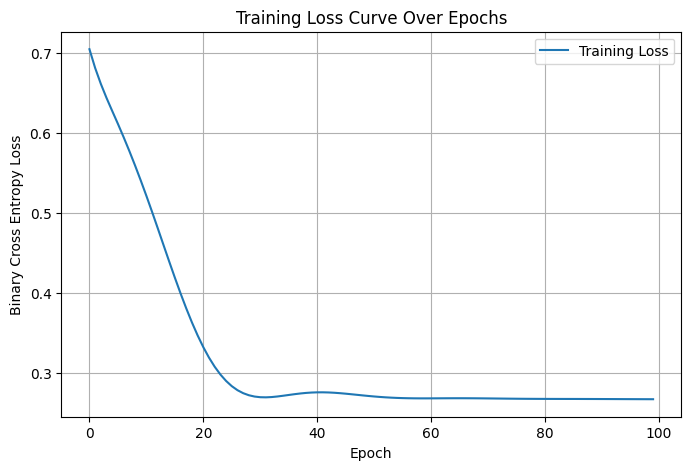

In [12]:
import matplotlib.pyplot as plt

# Train on full dataset and track loss over epochs
def train_and_plot_loss(model_class, X_tensor, y_tensor, epochs=100, lr=0.01):
    model = model_class()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    train_losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_tensor)
        loss = criterion(y_pred, y_tensor)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

    # Plot the training loss curve
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross Entropy Loss")
    plt.title("Training Loss Curve Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

# Call the function
trained_model = train_and_plot_loss(BinaryClassifier, X_tensor, y_tensor)


# The loss curve shows a steady decrease over the training epochs, which indicates that the model is learning effectively. As the number of epochs increases, the loss flattens out, suggesting that the model is starting to converge. There are no major spikes or increases in the loss, which means the training process is stable and there are no signs of overfitting.

In [13]:
# Variant A: Tanh activation + wider network
class VariantA(nn.Module):
    def __init__(self):
        super(VariantA, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

# Variant B: ReLU activation + SGD optimizer + lower learning rate
class VariantB(nn.Module):
    def __init__(self):
        super(VariantB, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

# Reusable k-fold trainer with optimizer override
def k_fold_train_variant(model_class, X_tensor, y_tensor, optimizer_fn=optim.Adam, lr=0.01, k=5, epochs=100):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    criterion = nn.BCELoss()
    val_losses = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor)):
        model = model_class()
        optimizer = optimizer_fn(model.parameters(), lr=lr)

        X_train, y_train = X_tensor[train_idx], y_tensor[train_idx]
        X_val, y_val = X_tensor[val_idx], y_tensor[val_idx]

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val).item()
            val_losses.append(val_loss)
            print(f"Fold {fold+1} Validation Loss: {val_loss:.4f}")

    avg_loss = np.mean(val_losses)
    print(f"\nAverage Validation Loss: {avg_loss:.4f}")
    return val_losses

# Run for Variant A
print("🔹 Variant A (Tanh + Wider Net):")
variant_a_losses = k_fold_train_variant(VariantA, X_tensor, y_tensor)

# Run for Variant B
print("\n🔸 Variant B (SGD + ReLU + Lower LR):")
variant_b_losses = k_fold_train_variant(VariantB, X_tensor, y_tensor, optimizer_fn=optim.SGD, lr=0.005)


🔹 Variant A (Tanh + Wider Net):
Fold 1 Validation Loss: 0.2653
Fold 2 Validation Loss: 0.2962
Fold 3 Validation Loss: 0.3059
Fold 4 Validation Loss: 0.2536
Fold 5 Validation Loss: 0.2421

Average Validation Loss: 0.2726

🔸 Variant B (SGD + ReLU + Lower LR):
Fold 1 Validation Loss: 0.7045
Fold 2 Validation Loss: 0.6515
Fold 3 Validation Loss: 0.6389
Fold 4 Validation Loss: 0.6182
Fold 5 Validation Loss: 0.6806

Average Validation Loss: 0.6587


In Variant A, I replaced ReLU with Tanh and used wider layers. This model performed better, with a lower average validation loss of 0.2726, suggesting Tanh helped the model converge more smoothly.

In Variant B, I switched the optimizer from Adam to SGD with a lower learning rate. This led to a higher loss of 0.6587, showing that optimizer choice has a major impact, and Adam was more effective here.


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_rel

# Step 5.1: Logistic Regression with 5-fold CV (accuracy)
log_reg = LogisticRegression()
log_reg_scores = cross_val_score(log_reg, X_scaled, y, cv=5, scoring='accuracy')
print("Logistic Regression Accuracy Scores:", log_reg_scores)
print("Logistic Regression Mean Accuracy:", log_reg_scores.mean())

# Step 5.2: DNN Accuracy using same k-fold logic
def k_fold_dnn_accuracy(model_class, X_tensor, y_tensor, k=5, epochs=100, lr=0.01):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []

    for train_idx, val_idx in kf.split(X_tensor):
        model = model_class()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.BCELoss()

        X_train, y_train = X_tensor[train_idx], y_tensor[train_idx]
        X_val, y_val = X_tensor[val_idx], y_tensor[val_idx]

        for _ in range(epochs):
            model.train()
            optimizer.zero_grad()
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()

        # Accuracy on validation set
        model.eval()
        with torch.no_grad():
            preds = (model(X_val) > 0.5).float()
            acc = (preds == y_val).float().mean().item()
            accuracies.append(acc)

    return np.array(accuracies)

# Step 5.3: Run DNN accuracy comparison
dnn_acc = k_fold_dnn_accuracy(BinaryClassifier, X_tensor, y_tensor)
print("DNN Accuracy Scores:", dnn_acc)
print("DNN Mean Accuracy:", dnn_acc.mean())

# Step 5.4: Hypothesis test (Paired t-test)
t_stat, p_val = ttest_rel(dnn_acc, log_reg_scores)
print(f"\nT-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")


Logistic Regression Accuracy Scores: [0.89   0.8825 0.92   0.875  0.88  ]
Logistic Regression Mean Accuracy: 0.8895
DNN Accuracy Scores: [0.89999998 0.88       0.875      0.89499998 0.88999999]
DNN Mean Accuracy: 0.8879999876022339

T-statistic: -0.1311
P-value: 0.9021


The DNN achieved a mean accuracy of 0.8880, while logistic regression achieved 0.8895.
A paired t-test gave a p-value of 0.9021, indicating that the difference is not statistically significant at the 0.05 level.